# Overview

This is the __intermediate level__ version of [question 2](../novice/Q2.ipynb) from the novice level. Previously we focused on the different type of plots and simple counting. This notebook focuses on conditional probability by using some of the features in the descriptions files to come up with a probabilty that a patient has a malignant lesion. The question we are trying to answer is who are the most at risk groups based on demographic (coming from the joint distribution)?

# Table of Content

1. [Setup](#setup_cell)
2. [Data Loading](#loading)
3. [Analysis](#analyze)
4. [Visualization](#viz_cell)
5. [Discussion](#discuss)


# Setup <a id='setup_cell'></a>
Import the appropriate packages

In [1]:
import os
from os import listdir
import json
import numpy as np
import seaborn as sns 
from matplotlib import pyplot as plt
import pandas as pd
import glob
from tqdm import tqdm

# Data Loading <a id='loading'></a>
Load the data similar to the novice level

In [2]:
img_filepaths = glob.glob('../../sample_imgs/*.jp*')
seg_filepaths = glob.glob('../../sample_segs/*.png')
dsc_filepaths = glob.glob('../../sample_dscs/*')

# Analysis <a id='analyze'></a>

Here we need to identify which columns we need for our analysis, then create a dataframe from data. <br>
Some of the columns from the description file are not going to be used (We remove the columns that we don't need, using *pandas.DataFrame.drop()*)

In [3]:
image_df = pd.DataFrame(columns= ["Age", "Site", "Status", "Diagnosis", "Confirm type", "Melanocytic", "Sex"])
for i in tqdm(range(len(dsc_filepaths))):
    with open(dsc_filepaths[i]) as json_file:
        j = json.load(json_file)
        try:
            image_df.loc[i] = list(j["meta"]["clinical"].values())
        except ValueError:
            error = i
image_df = image_df.drop(columns=["Melanocytic","Confirm type"])

100%|███████████████████████████████████████████████████████████████████████████| 69445/69445 [02:33<00:00, 450.99it/s]


### Below is the only function we will need for our analysis. Given a patient's Age, Site, and Sex we find the probability of them having a malignant lesion.
Since malignancy is independent we can use: **P(A|B)=P(A∩B)P(B)** <br>
Where A is Malignant and B is the combined probability of age, sex, and site.

P("Malignant"| "Age", "Site", "Sex") = P("Malignant" * "Age" * "Site" * "Sex") / P("Age" * "Site" * "Sex")

In [4]:
def get_probability(data, age, sex, site):
    """
    age:  The age of a patient
    sex:  The sex of a patient
    site: The location where the lesion is located
    
    returns the probability of a lesion being malignant given
    the above parameters
    """
    
    age_prob = len(data[data["Age"] == age])/len(data)
    site_prob = len(data[data["Site"] == site])/len(data)
    sex_prob = len(data[data["Sex"] == sex])/len(data)

    status_prob = len(data[data["Status"] == "malignant"])/len(data)
    

    return (round(status_prob * age_prob * site_prob * sex_prob,5) / round(age_prob * site_prob * sex_prob,5))

Here we drop rows with missing values and get all of the different combinations we need for our visualizations: <br>
Age <br>
Sex <br>
Site

In [5]:
image_df =image_df.dropna()

ages = list(set(image_df["Age"]))
sexes = list(set(image_df["Sex"]))
sites = list(set(image_df["Site"]))

Some of the sites are wrong, and ages are out of order so we need to do some preprocessing on the data. (Depending on the data, this step may  not be necessary so we use a few try statements)

In [6]:
try:
    ages.pop(ages.index(None))
    print("fixed ages")
except ValueError:
    ages = ages
try:
    sites.pop(sites.index('malignant'))
    print("Fixed sites")
except ValueError:
    sites = sites
try:
    sites.pop(sites.index('benign'))
    print("Fixed sites")
except ValueError:
    sites = sites

ages = sorted(ages)

Fixed sites
Fixed sites


Next we need to find the probability of a having a malignant lesion given a patient's age, sex, and lesion location <br>
Then we need to separate all of the patients into two groups: female & male

In [7]:
female_data = pd.DataFrame(columns=["Age", "Site", "Risk"])
male_data   = pd.DataFrame(columns=["Age", "Site", "Risk"])
for sex in sexes:
    i = 0
    for age in ages:
        for site in sites:
            if sex == "female":
                try:
                    female_data.loc[i] = [age, site, round(get_probability(image_df, age, sex, site),5)]
                    
                except ZeroDivisionError:
                    female_data.loc[i] = [age, site, 0]
                i += 1
            else:
                try:
                    male_data.loc[i] = [age, site, round(get_probability(image_df, age, sex, site),5)]
                except ZeroDivisionError:
                    male_data.loc[i] = [age, site, 0]
                i += 1

# Visualization <a id='viz_cell'></a>

### Risk of having a malignant lesion for females

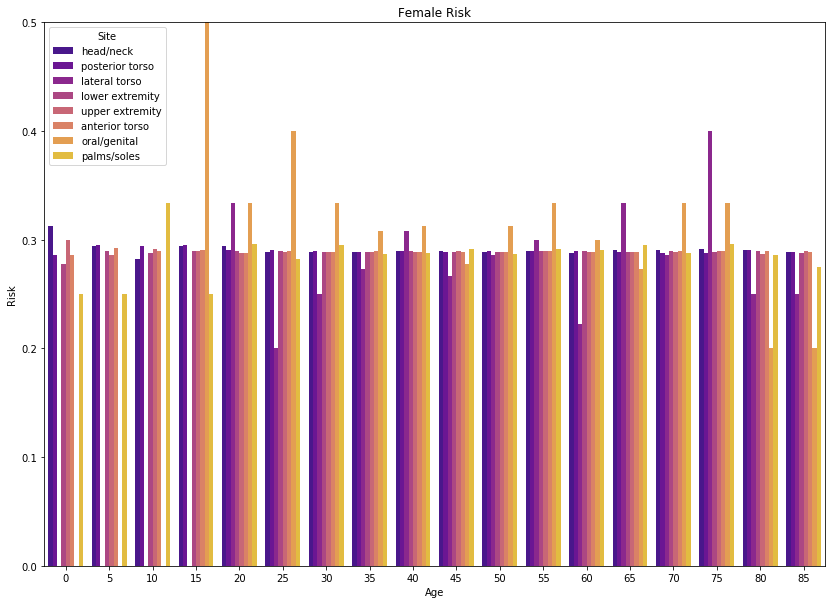

In [8]:
%matplotlib inline
fig = plt.figure(figsize=(14,10))
plt.ylim(0, .5)
plt.title("Female Risk")
sns.barplot(x="Age", y="Risk", hue="Site", data=female_data, palette="plasma")
plt.savefig("../intermediate_Q2_female.png")
plt.show()

### Risk of having a malignant lesion for males

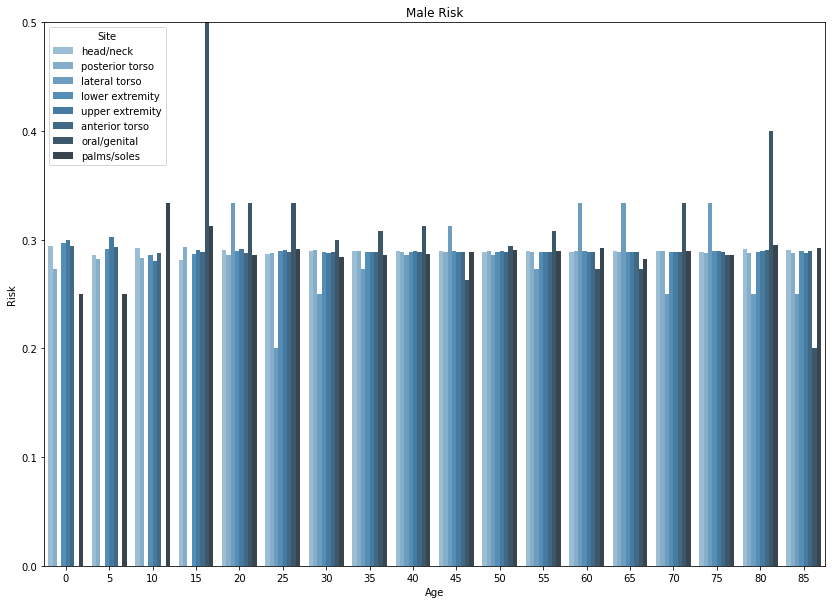

In [9]:
%matplotlib inline
fig = plt.figure(figsize=(14,10))
plt.ylim(0, 0.5)
plt.title("Male Risk")
sns.barplot(x="Age", y="Risk", hue="Site", data=male_data, palette="Blues_d")
plt.savefig("../intermediate_Q2_male.png")
plt.show()

For the case when malignancy is dependent:
M = Malignant,
A = Age,
S = Sex,
T = Site <br>
P(M|A,S,T) = P(M|W,T) <br>
P(M|W,T) = P(M|Z) <br>
P(M|Z) = P(M n Z) / P(Z) <br>

P(M n Z) / P(Z) = P(M n (W n T)) / P(W n T) <br>
P(M n W n T) / P(W n T) <br>
P(W n T) = P(W) * P(T|W) <br>

P(W) = P(A n S) <br>
P(T|W) = P(T n W) / P(W) <br>
P(T n W) = P(T n (A n S)) <br>

# Discussion <a id='discuss'></a>
What did you find? Who the person that is most at risk? What about the least?